In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scripts.utils import info_map
from scripts.arena import Arena, Aperture, Mouse, visualize_arena
from tqdm import tqdm
import os

In [2]:
arena = Arena(length=60, width=60, height=50)
aperture = Aperture(arena_width=60, arena_height=50, arena_length=60, gap_width=10)
circleL = (arena.width/2 - aperture.gap_width, arena.width, arena.height/2)
circleR = (arena.width/2 + aperture.gap_width, arena.width, arena.height/2)



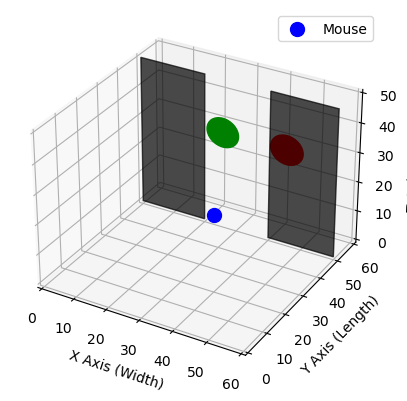

In [3]:
mouse = Mouse(40, 20, 25)
visualize_arena(arena, mouse, aperture)

In [4]:
def get_visibility(source, target, aperture):
    v_t2Lwall = np.subtract(aperture.left_wall_edge + (target[2],), target)
    v_t2Lwall = v_t2Lwall/np.linalg.norm(v_t2Lwall)
    v_t2Rwall = np.subtract(aperture.right_wall_edge + (target[2],), target)
    v_t2Rwall = v_t2Rwall/np.linalg.norm(v_t2Rwall)

    # Vector from target to source (normalized)
    v_t2s = np.subtract(source, target)
    v_t2s = v_t2s / np.linalg.norm(v_t2s)

    # Cross products to determine the relative position of v_target2source
    cross_LS = np.cross(v_t2Lwall[:2], v_t2s[:2])
    cross_RS = np.cross( v_t2s[:2], v_t2Rwall[:2],)
    # Check if v_target2source is between the left and right wall vectors

    if cross_LS >=0 and cross_RS >=0:
        return True
    else:
        return False


def get_visible_angles(source, circle_center, radius, aperture):
    """
    Calculate the visible area of a circle from a given point by checking the visibility
    of various points on the circle's perimeter.
    """
    d_theta = np.pi/180  # Increase for higher accuracy
    angles = np.arange(0, 2 * np.pi, d_theta)
    visible_angles = []
    
    for i in range(len(angles)-1):
        # Parametrize the circle
        x_circle = circle_center[0] + radius * np.cos(angles[i])
        z_circle = circle_center[2] + radius * np.sin(angles[i])
        y_circle = circle_center[1]  # Y remains the same for a circle in the YZ plane
        
        circle_point = (x_circle, y_circle, z_circle)
        flag = get_visibility(source, circle_point, aperture)
        if flag:
            visible_angles.append(angles[i])
    #print(len(angles), len(visible_angles))
    #area  = get_segment_area(visible_angles, radius)
    return visible_angles

def get_segment_area(angles, radius):
    if len(angles)==0:
        return (0, 0)
    else:
        # Sort the angles
        angles = np.sort(angles)
        # Calculate the differences between consecutive angles
        if (0 in angles):
            diffs = np.diff(angles, append=angles[-1]-angles[0])# + 2 * np.pi - angles[-1])
        else:
            diffs = np.abs(np.diff(angles, append=angles[0]))
        # Find the largest gap, which is the central angle of the segment
        central_angle = np.max([np.max(diffs), np.min(diffs)])
        #print(central_angle)
        # Calculate the area of the circular segment
        # Area of segment = 0.5 * radius^2 * (theta - sin(theta))
        area = 0.5 * radius**2 * (central_angle - np.sin(central_angle))

        # area compliment 
        area_c = np.abs(np.pi*radius**2 - area)
        return np.array([area, area_c])

def infoMetric(area1, area2):
    return 0.5 * np.abs(area1 + area2)

def info_map(arena, circle1_center, circle2_center, aperture, radius):
    x_resolution = arena.width
    y_resolution = arena.length - aperture.gap_width

    x = np.linspace(0, arena.length, x_resolution)
    y = np.linspace(0, arena.width, y_resolution)

    info_mat = np.zeros((x_resolution, y_resolution))
    print(info_mat.shape, '\n')
    # Iterate through a grid of points in the arena
    for i in tqdm(range(x_resolution)):
        for j in range(y_resolution):
            source = (x[i], y[j], 20)
            visible_anglesL = get_visible_angles(source, circle1_center, radius, aperture)
            visible_anglesR = get_visible_angles(source, circle2_center, radius, aperture)

            area_circle1 = get_segment_area(visible_anglesL, radius)
            area_circle2 = get_segment_area(visible_anglesR, radius)

            # Check whether to use major or minor segment area

            # larger element of area_circle is last element
            if source[0] > arena.length/2:
                A1 = np.max(area_circle1)
                A2 = np.min(area_circle2)
            elif source[0] < arena.length/2:
                A1 = np.min(area_circle1)
                A2 = np.max(area_circle2)
            else: 
                A1 = area_circle1[0]
                A2 = area_circle2[0]    

            info_mat[i, j] = infoMetric(A1, A2) 
    return info_mat

In [5]:
circleR

(40.0, 60, 25.0)

In [6]:
source = (10, 0, 20)
target = (40, 60, 25)
x=get_visible_angles(source, circleL, 5, aperture)
v = get_visibility(source, target, aperture)
print(x)
a =get_segment_area(x, 5)
print(a[1])


NameError: name 'get_visible_area' is not defined

In [7]:
info_mat = info_map(arena, circleL, circleR, aperture, radius=5)


(60, 50) 



100%|██████████| 60/60 [01:27<00:00,  1.45s/it]


In [8]:
BASE_PATH = "/Users/reecekeller/Documents/Xaq/act_sense/act_sense/data/"
np.save(os.path.join(BASE_PATH, 'info_matrix.npy'), info_mat)

In [9]:
info_map = np.load(BASE_PATH + 'info_matrix.npy')

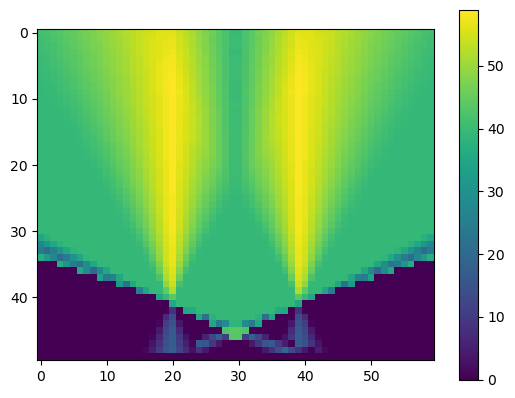

In [13]:
plt.imshow(info_map.T)
plt.colorbar()
plt.show()


In [ ]:
circleR

(40.0, 60, 25.0)

In [ ]:
def get_segment_area(angles, radius):
    if len(angles)==0:
        return (0, 0)
    else:
        # Sort the angles
        angles = np.sort(angles)
        # Calculate the differences between consecutive angles
        if (0 in angles):
            diffs = np.diff(angles, append=angles[-1]-angles[0])# + 2 * np.pi - angles[-1])
        else:
            diffs = np.abs(np.diff(angles, append=angles[0]))
        # Find the largest gap, which is the central angle of the segment
        central_angle = np.max([np.max(diffs), np.min(diffs)])
        #print(central_angle)
        # Calculate the area of the circular segment
        # Area of segment = 0.5 * radius^2 * (theta - sin(theta))
        area = 0.5 * radius**2 * (central_angle - np.sin(central_angle))

        # area compliment 
        area_c = np.abs(np.pi*radius**2 - area)
        return np.array([area, area_c])

In [ ]:
x = np.array([120, 130, 180, 200])
np.abs(np.diff(x, append=x[0]))
x = np.array([0, 10, 50, 100, 150, 220, 260, 300, 350, 359])
np.diff(x, append=x[-1]-x[0])

array([10, 40, 50, 50, 70, 40, 40, 50,  9,  0])

In [ ]:
x = np.array([0, 10, 20, 25, 35, 340, 350, 355])
np.diff(x, append=x[-1]-x[0])
x = np.array([70, 80, 90, 100, 120, 140, 160, 180, 200, 220, 240, 260, 270, 290])
np.abs(np.diff(x, append=x[0]))


array([  10,   10,   10,   20,   20,   20,   20,   20,   20,   20,   20,
         10,   20, -220])

In [ ]:
source = (20, 20, 25)
target = (45, 60, 25)

flag = get_visibility(source, target, aperture)
a_L=get_visible_angles(source, circleL, 5, aperture)
a_R=get_visible_angles(source, circleR, 5, aperture)

# confirmed: less points in a_R than a_L for this source and target
area_circle1 = get_segment_area(a_L, 5)
area_circle2 = get_segment_area(a_R, 5)
d_theta = np.pi/180  # Increase for higher accuracy
angles = np.arange(0, 2 * np.pi, d_theta)

if source[0] > arena.length/2:
    A1 = np.max(area_circle1)
    A2 = np.min(area_circle2)
elif source[0] < arena.length/2:
    A1 = np.min(area_circle1)
    A2 = np.max(area_circle2)
else: 
    A1 = area_circle1[0]
    A2 = area_circle2[0]    
print(len(a_L), len(a_R))
print(area_circle1, area_circle2)
print(A1, A2, 0.5*(A1+A2))


180 359
[39.26990817 39.26990817] [1.10760332e-05 7.85398053e+01]
39.269908169872416 78.53980526371159 58.904856716792


In [ ]:
0 in a_L

True

In [ ]:
source = (40, 20, 25)
#target = (45, 60, 25)

flag = get_visibility(source, target, aperture)
a_L=get_visible_angles(source, circleL, 5, aperture)
a_R=get_visible_angles(source, circleR, 5, aperture)

# confirmed: less points in a_R than a_L for this source and target
area_circle1 = get_segment_area(a_L, 5)
area_circle2 = get_segment_area(a_R, 5)
d_theta = np.pi/180  # Increase for higher accuracy
angles = np.arange(0, 2 * np.pi, d_theta)

if source[0] > arena.length/2:
    A1 = np.max(area_circle1)
    A2 = np.min(area_circle2)
elif source[0] < arena.length/2:
    A1 = np.min(area_circle1)
    A2 = np.max(area_circle2)
else: 
    A1 = area_circle1[0]
    A2 = area_circle2[0]    
print(len(a_L), len(a_R))
print(area_circle1, area_circle2)
print(A1, A2, 0.5*(A1+A2))


359 181
[1.10760332e-05 7.85398053e+01] [39.26990817 39.26990817]
78.53980526371159 39.269908169872416 58.904856716792


In [ ]:
np.pi*5**2

78.53981633974483